/tmp/ipykernel_7127/924126567.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
/tmp/ipykernel_7127/924126567.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(data[block], exam_grades)


Correlation between IC Total Study Time and Exam Grades: nan (p-value = nan)
Correlation between Room Total Study Time and Exam Grades: -0.41 (p-value = 0.312)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = nan, p-value = nan
  17.00 - 21.00: Correlation = nan, p-value = nan
  21.00 - 00.00: Correlation = nan, p-value = nan
  00.00 - 03.00: Correlation = -0.41, p-value = 0.312


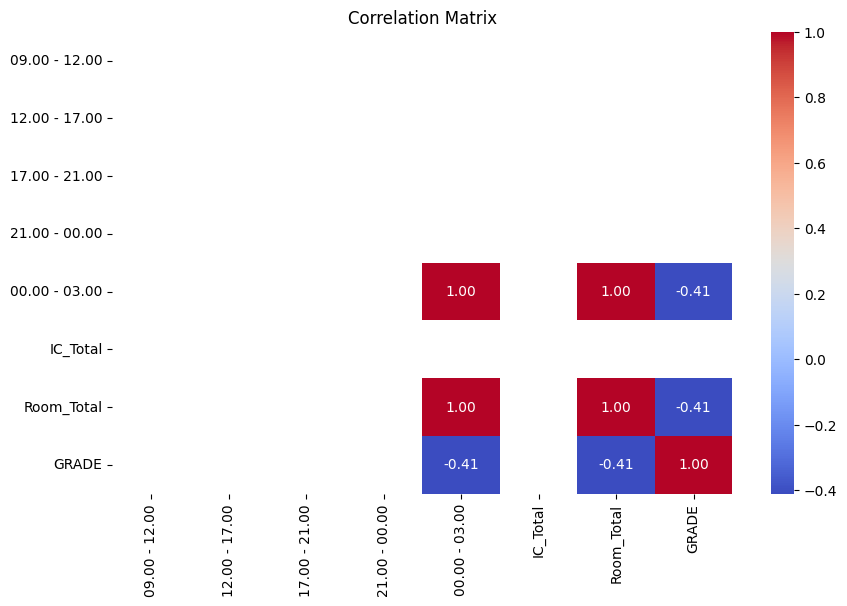

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the datasets
study_file_path = 'processed_data/CS300_data.txt' 
exam_file_path = 'processed_data/exam_grades.txt'

# Load study data
study_data = pd.read_csv(study_file_path)

# Load exam grades data and clean column names
exam_data = pd.read_csv(exam_file_path)
exam_data.columns = exam_data.columns.str.strip()  

# Merge study data with exam grades on the date
study_data['DATE'] = pd.to_datetime(study_data['DATE'], format='%d.%m.%Y')
exam_data['DATE'] = pd.to_datetime(exam_data['DATE'], format='%d.%m.%Y')
data = pd.merge(study_data, exam_data, on='DATE', how='inner')

# Step 2: Extract relevant columns
exam_grades = data['GRADE']  # Adjusted for your dataset
study_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
locations = ['IC', 'Room']  # Assuming study location is binary (IC or Room)

# Step 3: Add a new column for total time spent in IC and Room
data['IC_Total'] = data[data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
data['Room_Total'] = data[data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
data.fillna(0, inplace=True)

# Step 4: Calculate correlations
# Correlation for study locations
ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)

# Correlation for study time blocks
time_block_corrs = {}
for block in study_blocks:
    corr, p_value = pearsonr(data[block], exam_grades)
    time_block_corrs[block] = (corr, p_value)

# Step 5: Display results
print(f"Correlation between IC Total Study Time and Exam Grades: {ic_corr:.2f} (p-value = {ic_p_value:.3f})")
print(f"Correlation between Room Total Study Time and Exam Grades: {room_corr:.2f} (p-value = {room_p_value:.3f})")
print("\nCorrelations for Time Blocks:")
for block, (corr, p_value) in time_block_corrs.items():
    print(f"  {block}: Correlation = {corr:.2f}, p-value = {p_value:.3f}")

# Step 6: Visualize correlations (optional)
# Correlation matrix
correlation_matrix = data[study_blocks + ['IC_Total', 'Room_Total', 'GRADE']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Correlation between IC Total Study Time and Exam Grades: nan (p-value = nan)
Correlation between Room Total Study Time and Exam Grades: nan (p-value = nan)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = nan, p-value = nan
  17.00 - 21.00: Correlation = nan, p-value = nan
  21.00 - 00.00: Correlation = nan, p-value = nan
  00.00 - 03.00: Correlation = nan, p-value = nan


/tmp/ipykernel_7127/2279333670.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)
/tmp/ipykernel_7127/2279333670.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
/tmp/ipykernel_7127/2279333670.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)
/tmp/ipykernel_7127/2279333670.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(data[block], exam_grades)


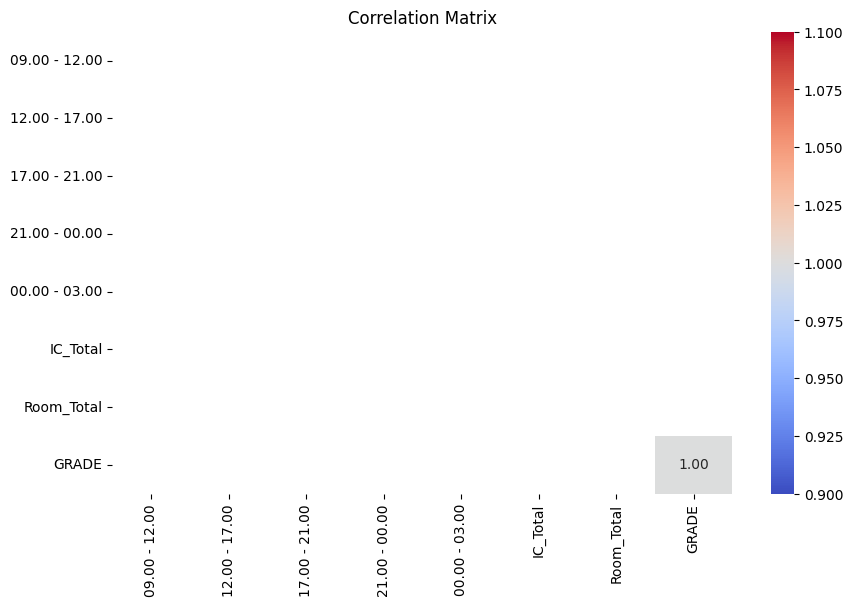

In [5]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the datasets
study_file_path = 'processed_data/CS303_data.txt'  
exam_file_path = 'processed_data/exam_grades.txt'

# Load study data
study_data = pd.read_csv(study_file_path)

# Load exam grades data and clean column names
exam_data = pd.read_csv(exam_file_path)
exam_data.columns = exam_data.columns.str.strip() 

# Merge study data with exam grades on the date
study_data['DATE'] = pd.to_datetime(study_data['DATE'], format='%d.%m.%Y')
exam_data['DATE'] = pd.to_datetime(exam_data['DATE'], format='%d.%m.%Y')
data = pd.merge(study_data, exam_data, on='DATE', how='inner')

# Step 2: Extract relevant columns
exam_grades = data['GRADE']  # Adjusted for your dataset
study_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
locations = ['IC', 'Room']  # Assuming study location is binary (IC or Room)

# Step 3: Add a new column for total time spent in IC and Room
data['IC_Total'] = data[data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
data['Room_Total'] = data[data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
data.fillna(0, inplace=True)

# Step 4: Calculate correlations
# Correlation for study locations
ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)

# Correlation for study time blocks
time_block_corrs = {}
for block in study_blocks:
    corr, p_value = pearsonr(data[block], exam_grades)
    time_block_corrs[block] = (corr, p_value)

# Step 5: Display results
print(f"Correlation between IC Total Study Time and Exam Grades: {ic_corr:.2f} (p-value = {ic_p_value:.3f})")
print(f"Correlation between Room Total Study Time and Exam Grades: {room_corr:.2f} (p-value = {room_p_value:.3f})")
print("\nCorrelations for Time Blocks:")
for block, (corr, p_value) in time_block_corrs.items():
    print(f"  {block}: Correlation = {corr:.2f}, p-value = {p_value:.3f}")

# Step 6: Visualize correlations (optional)
# Correlation matrix
correlation_matrix = data[study_blocks + ['IC_Total', 'Room_Total', 'GRADE']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


/tmp/ipykernel_7127/964744654.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)
/tmp/ipykernel_7127/964744654.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
/tmp/ipykernel_7127/964744654.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)
/tmp/ipykernel_7127/964744654.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(data[block], exam_grades)


Correlation between IC Total Study Time and Exam Grades: nan (p-value = nan)
Correlation between Room Total Study Time and Exam Grades: nan (p-value = nan)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = nan, p-value = nan
  17.00 - 21.00: Correlation = nan, p-value = nan
  21.00 - 00.00: Correlation = nan, p-value = nan
  00.00 - 03.00: Correlation = nan, p-value = nan


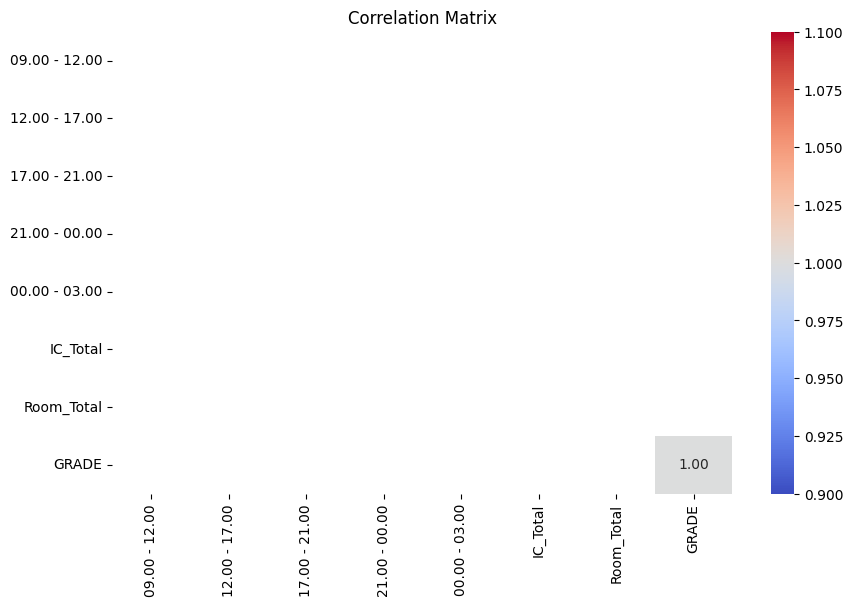

In [6]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the datasets
study_file_path = 'processed_data/CS308_data.txt' 
exam_file_path = 'processed_data/exam_grades.txt'

# Load study data
study_data = pd.read_csv(study_file_path)

# Load exam grades data and clean column names
exam_data = pd.read_csv(exam_file_path)
exam_data.columns = exam_data.columns.str.strip() 

# Merge study data with exam grades on the date
study_data['DATE'] = pd.to_datetime(study_data['DATE'], format='%d.%m.%Y')
exam_data['DATE'] = pd.to_datetime(exam_data['DATE'], format='%d.%m.%Y')
data = pd.merge(study_data, exam_data, on='DATE', how='inner')

# Step 2: Extract relevant columns
exam_grades = data['GRADE']  # Adjusted for your dataset
study_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
locations = ['IC', 'Room']  # Assuming study location is binary (IC or Room)

# Step 3: Add a new column for total time spent in IC and Room
data['IC_Total'] = data[data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
data['Room_Total'] = data[data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
data.fillna(0, inplace=True)

# Step 4: Calculate correlations
# Correlation for study locations
ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)

# Correlation for study time blocks
time_block_corrs = {}
for block in study_blocks:
    corr, p_value = pearsonr(data[block], exam_grades)
    time_block_corrs[block] = (corr, p_value)

# Step 5: Display results
print(f"Correlation between IC Total Study Time and Exam Grades: {ic_corr:.2f} (p-value = {ic_p_value:.3f})")
print(f"Correlation between Room Total Study Time and Exam Grades: {room_corr:.2f} (p-value = {room_p_value:.3f})")
print("\nCorrelations for Time Blocks:")
for block, (corr, p_value) in time_block_corrs.items():
    print(f"  {block}: Correlation = {corr:.2f}, p-value = {p_value:.3f}")

# Step 6: Visualize correlations (optional)
# Correlation matrix
correlation_matrix = data[study_blocks + ['IC_Total', 'Room_Total', 'GRADE']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Correlation between IC Total Study Time and Exam Grades: nan (p-value = nan)
Correlation between Room Total Study Time and Exam Grades: nan (p-value = nan)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = nan, p-value = nan
  17.00 - 21.00: Correlation = nan, p-value = nan
  21.00 - 00.00: Correlation = nan, p-value = nan
  00.00 - 03.00: Correlation = nan, p-value = nan


/tmp/ipykernel_7127/3823824534.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)
/tmp/ipykernel_7127/3823824534.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
/tmp/ipykernel_7127/3823824534.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)
/tmp/ipykernel_7127/3823824534.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(data[block], exam_grades)


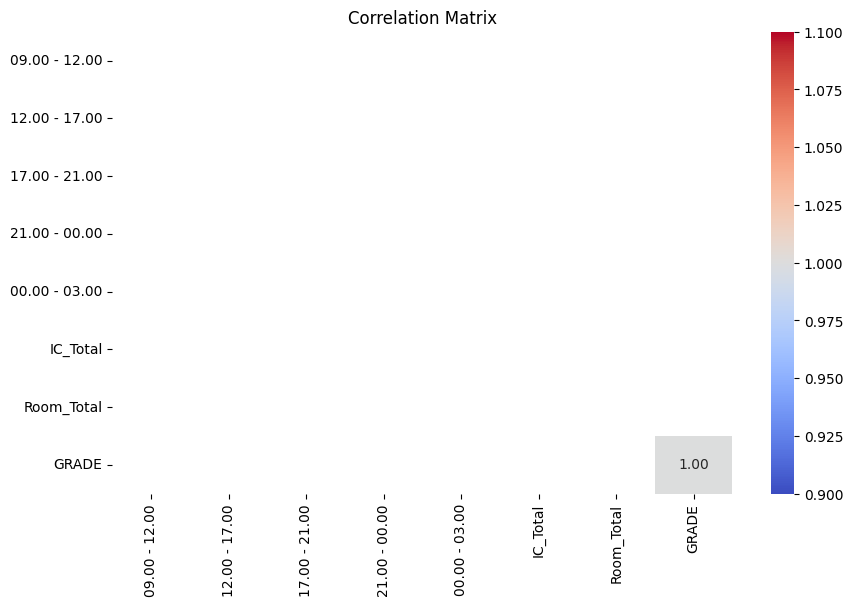

In [7]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the datasets
study_file_path = 'processed_data/DSA210_data.txt'  
exam_file_path = 'processed_data/exam_grades.txt'

# Load study data
study_data = pd.read_csv(study_file_path)

# Load exam grades data and clean column names
exam_data = pd.read_csv(exam_file_path)
exam_data.columns = exam_data.columns.str.strip()  

# Merge study data with exam grades on the date
study_data['DATE'] = pd.to_datetime(study_data['DATE'], format='%d.%m.%Y')
exam_data['DATE'] = pd.to_datetime(exam_data['DATE'], format='%d.%m.%Y')
data = pd.merge(study_data, exam_data, on='DATE', how='inner')

# Step 2: Extract relevant columns
exam_grades = data['GRADE']  # Adjusted for your dataset
study_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
locations = ['IC', 'Room']  # Assuming study location is binary (IC or Room)

# Step 3: Add a new column for total time spent in IC and Room
data['IC_Total'] = data[data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
data['Room_Total'] = data[data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
data.fillna(0, inplace=True)

# Step 4: Calculate correlations
# Correlation for study locations
ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)

# Correlation for study time blocks
time_block_corrs = {}
for block in study_blocks:
    corr, p_value = pearsonr(data[block], exam_grades)
    time_block_corrs[block] = (corr, p_value)

# Step 5: Display results
print(f"Correlation between IC Total Study Time and Exam Grades: {ic_corr:.2f} (p-value = {ic_p_value:.3f})")
print(f"Correlation between Room Total Study Time and Exam Grades: {room_corr:.2f} (p-value = {room_p_value:.3f})")
print("\nCorrelations for Time Blocks:")
for block, (corr, p_value) in time_block_corrs.items():
    print(f"  {block}: Correlation = {corr:.2f}, p-value = {p_value:.3f}")

# Step 6: Visualize correlations (optional)
# Correlation matrix
correlation_matrix = data[study_blocks + ['IC_Total', 'Room_Total', 'GRADE']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Correlation between IC Total Study Time and Exam Grades: -0.41 (p-value = 0.312)
Correlation between Room Total Study Time and Exam Grades: 0.19 (p-value = 0.654)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = -0.41, p-value = 0.312
  17.00 - 21.00: Correlation = -0.41, p-value = 0.312
  21.00 - 00.00: Correlation = -0.31, p-value = 0.453
  00.00 - 03.00: Correlation = 0.19, p-value = 0.654


/tmp/ipykernel_7127/2727539253.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(data[block], exam_grades)


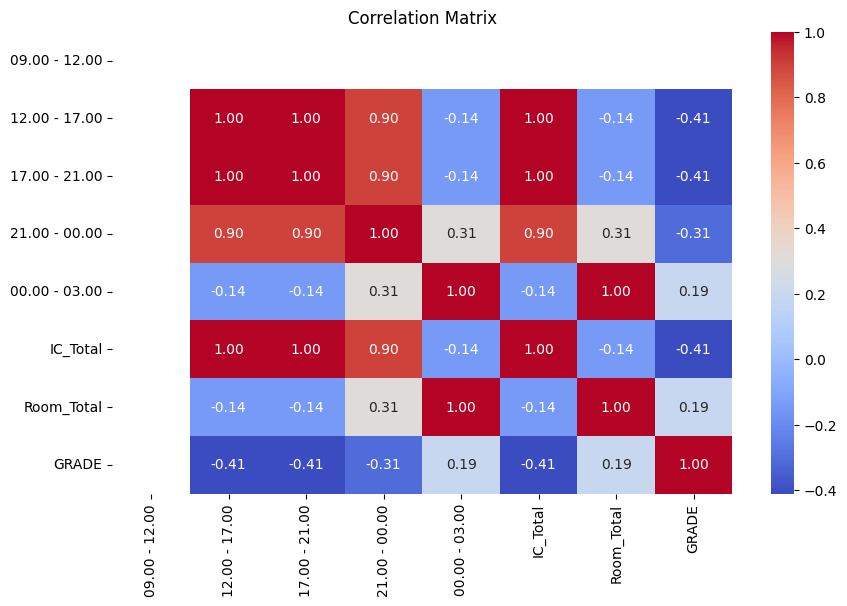

In [8]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the datasets
study_file_path = 'processed_data/MATH204_data.txt'  
exam_file_path = 'processed_data/exam_grades.txt'

# Load study data
study_data = pd.read_csv(study_file_path)

# Load exam grades data and clean column names
exam_data = pd.read_csv(exam_file_path)
exam_data.columns = exam_data.columns.str.strip()  

# Merge study data with exam grades on the date
study_data['DATE'] = pd.to_datetime(study_data['DATE'], format='%d.%m.%Y')
exam_data['DATE'] = pd.to_datetime(exam_data['DATE'], format='%d.%m.%Y')
data = pd.merge(study_data, exam_data, on='DATE', how='inner')

# Step 2: Extract relevant columns
exam_grades = data['GRADE']  # Adjusted for your dataset
study_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
locations = ['IC', 'Room']  # Assuming study location is binary (IC or Room)

# Step 3: Add a new column for total time spent in IC and Room
data['IC_Total'] = data[data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
data['Room_Total'] = data[data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
data.fillna(0, inplace=True)

# Step 4: Calculate correlations
# Correlation for study locations
ic_corr, ic_p_value = pearsonr(data['IC_Total'], exam_grades)
room_corr, room_p_value = pearsonr(data['Room_Total'], exam_grades)

# Correlation for study time blocks
time_block_corrs = {}
for block in study_blocks:
    corr, p_value = pearsonr(data[block], exam_grades)
    time_block_corrs[block] = (corr, p_value)

# Step 5: Display results
print(f"Correlation between IC Total Study Time and Exam Grades: {ic_corr:.2f} (p-value = {ic_p_value:.3f})")
print(f"Correlation between Room Total Study Time and Exam Grades: {room_corr:.2f} (p-value = {room_p_value:.3f})")
print("\nCorrelations for Time Blocks:")
for block, (corr, p_value) in time_block_corrs.items():
    print(f"  {block}: Correlation = {corr:.2f}, p-value = {p_value:.3f}")

# Step 6: Visualize correlations (optional)
# Correlation matrix
correlation_matrix = data[study_blocks + ['IC_Total', 'Room_Total', 'GRADE']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


As can be seen I did not get meaningful p-values from Pearson Correlation Coefficient analysis. Only meaningful results I get were from MATH204. In the case of MATH204, results are like this:

Correlation between IC Total Study Time and Exam Grades: -0.41 (p-value = 0.312)
Correlation between Room Total Study Time and Exam Grades: 0.19 (p-value = 0.654)

Correlations for Time Blocks:
  09.00 - 12.00: Correlation = nan, p-value = nan
  12.00 - 17.00: Correlation = -0.41, p-value = 0.312
  17.00 - 21.00: Correlation = -0.41, p-value = 0.312
  21.00 - 00.00: Correlation = -0.31, p-value = 0.453

Since p-values are greater than significance level, we cannot get any significant conclusion.